# Data preparation

## Import libraries

In [1]:
import sys, os, glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Add the path to the src folder to the path
module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Verify if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)


Device: cuda:0


## Load and crop images

We assume that the "Qflow2.0" dataset are stored in the `data/raw/` directory. The link to the dataset is provided in the `data/external` folder.
We also assume that you want to only train a model for state regime detection on the "Qflow2.0" dataset(the sim_normal data is for that).
This cell is supposed to be run only once if save_data is set to True.
The cropped images are stored in the `data/interim/` directory.

In [2]:
from ml_tools.data.subimage_generator import SubImageGenerator

# Set up the path to the data
data_path = '../data/raw/data_qflow_v2/simulated/sim_normal/'
data_files = glob.glob(data_path + '*.hdf5')

for raw_data_file in data_files:
    generator = SubImageGenerator(border_margin=20)

    cropped_data = generator.generate_multiple_sub_images(
        raw_data_file, save_images=True, return_images=False)

## Load subimages and create a dataset for training
The current step we need to do is data preparation. We need to load the subimages, make the preleminary modifications and create a dataset for training and testing. For that we will use an instance of the DatasetPreparation class. We need to specify here what type of label we want. Options are 'state' or 'data_quality' depending on what we want to train the model for. If we want to save the dataset you need to specify the path where you want to save it(it should be in data/interim/).You can specify a single .npz file,a whole directory(you must set the flag use_all_data) or the whole dataset in dictonary form from the cell above.


In [3]:
from ml_tools.preprocessing.dataset_preparator import DatasetPreparator

subimage_folder_path = '../data/interim/data_qflow_v2/simulated/sim_normal/'

preparator = DatasetPreparator()

train_data, train_labels, validation_data, validation_labels = preparator.prepare_dataset(
                        path_or_dict=subimage_folder_path,
                        save_path="../data/interim/data_qflow_v2/simulated/sim_normal",
                        train_validation_split=0.75, 
                        label_key_name='state', 
                        )

Plot a few images to check if everything is ok

In [4]:
# # Plot a few images to check if everything is ok
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# ax[0].imshow(train_data[0, :, :, 0])
# ax[1].imshow(train_data[1, :, :, 0])
# ax[2].imshow(train_data[2, :, :, 0])
# plt.show()


## Preprocess the data
Now that we have the dataset created we need to preprocess it. For that we will use an instance of the SubImagePreprocessor class. The preprocessed dataset should be saved in the data/processed/ directory.

In [5]:
from ml_tools.preprocessing.subimage_preprocessor import SubImagePreprocessor


# Define the path to the dataset
dataset_path = '../data/interim/data_qflow_v2/simulated/sim_normal/unprocessed_dataset/'

# Load training data and labels
train_data_path = dataset_path + 'training/training_data.npz'
train_labels_path = dataset_path + 'training/training_labels.npz'
validation_data_path = dataset_path + 'validation/validation_data.npz'
validation_labels_path = dataset_path + 'validation/validation_labels.npz'

train_data = np.load(train_data_path)['training_data']
train_labels = np.load(train_labels_path)['training_labels']
validation_data = np.load(validation_data_path)['validation_data']
validation_labels = np.load(validation_labels_path)['validation_labels']
	
preprocessor = SubImagePreprocessor(
    auto_invert=False,
    noise_reduction=[],
    clip_value=None,
    cutoff_value= None
)

save_path = '../data/processed/data_qflow_v2/simulated/sim_normal/'

processed_train_data, proccessed_train_labels = preprocessor.preprocess_subimages(
    train_data,
    train_labels,
    train_or_validation='training',
    save_path=save_path
    )
processed_validation_data,processed_validation_labels = preprocessor.preprocess_subimages(
    validation_data,
    validation_labels,
    train_or_validation='validation',
    save_path=save_path
    )


In [6]:
# # Plot a few images at random
# # Generate 3 random index
# random_idx = np.random.randint(0, train_data.shape[0], 3)
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# ax[0].set_title('label:'+str(train_labels[random_idx[0]]))
# ax[1].set_title('label:'+str(train_labels[random_idx[1]]))
# ax[2].set_title('label:'+str(train_labels[random_idx[2]]))
# ax[0].imshow(processed_train_data[random_idx[0], :, :, 0])
# ax[1].imshow(processed_train_data[random_idx[1], :, :, 0])
# ax[2].imshow(processed_train_data[random_idx[2], :, :, 0])
# # Plot the original images 
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# ax[0].imshow(train_data[random_idx[0], :, :, 0])
# ax[1].imshow(train_data[random_idx[1], :, :, 0])
# ax[2].imshow(train_data[random_idx[2], :, :, 0])
# # Plot the labels as titles 
# plt.show()

In [7]:
# # Plotting histograms
# fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# # Before processing
# for i, idx in enumerate(random_idx):
#     ax[0, i].hist(train_data[idx].flatten(), bins=50, color='blue', alpha=0.7)
#     ax[0, i].set_title(f'Original Image {i+1} Histogram')
#     ax[0, i].set_xlabel('Pixel Intensity')
#     ax[0, i].set_ylabel('Frequency')

# # After processing
# for i, idx in enumerate(random_idx):
#     ax[1, i].hist(processed_train_data[idx].flatten(), bins=50, color='green', alpha=0.7)
#     ax[1, i].set_title(f'Processed Image {i+1} Histogram')
#     ax[1, i].set_xlabel('Pixel Intensity')
#     ax[1, i].set_ylabel('Frequency')

# plt.tight_layout()
# plt.show()


# Model creation and training

In [8]:
# Define the path to the dataset
dataset_path = '../data/processed/data_qflow_v2/simulated/sim_normal/processed_dataset/'

# Load training data and labels
train_data_path = dataset_path + 'training/processed_training_data.npz'
train_labels_path = dataset_path + 'training/processed_training_labels.npz'
train_data = np.load(train_data_path)['data']
train_labels = np.load(train_labels_path)['labels']

validation_data_path = dataset_path + 'validation/processed_validation_data.npz'
validation_labels_path = dataset_path + 'validation/processed_validation_labels.npz'
validation_data = np.load(validation_data_path)['data']
validation_labels = np.load(validation_labels_path)['labels']

print("Shape of training data: ", train_data.shape)
print("Shape of training labels: ", train_labels.shape)
print("Shape of validation data: ", validation_data.shape)
print("Shape of validation labels: ", validation_labels.shape)

Shape of training data:  (72555, 30, 30, 1)
Shape of training labels:  (72555, 5)
Shape of validation data:  (24600, 30, 30, 1)
Shape of validation labels:  (24600, 5)


In [9]:
train_data_transpose = np.transpose(train_data, (0, 3, 1, 2))
validation_data_transpose = np.transpose(validation_data, (0, 3, 1, 2))

In [10]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
import mlflow
import torch

from ml_tools.models.state_estimator import StateEstimator
from ml_tools.models.model_utils import prepare_dataloader


# Auto log all the parameters, metrics, and models
mlflow.pytorch.autolog()

train_dataloader = prepare_dataloader(train_data_transpose, train_labels, batch_size=64, seed=42)
val_dataloader = prepare_dataloader(validation_data_transpose, validation_labels, batch_size=128, seed=42)

model = StateEstimator(model_opt='noise_opt')

# Print the model summary
print(model)

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.00,
   patience=3,
   verbose=False,
   mode='min'
)

trainer = Trainer(callbacks=[early_stop_callback])

with mlflow.start_run() as run:
    trainer.fit(model, train_dataloader, val_dataloader)

# Save the model
torch.save(model.state_dict(), '../models/state_estimator/state_estimator_early_stopping.pt')

/local/rbals/miniconda3/envs/colibri/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /local/rbals/miniconda3/envs/colibri/lib/python3.10/ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


StateEstimator(
  (features): Sequential(
    (0): Conv2d(1, 22, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): Conv2d(22, 22, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (3): ReLU()
    (4): Conv2d(22, 35, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (5): ReLU()
    (6): Conv2d(35, 35, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (7): ReLU()
  )
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=35, out_features=5, bias=True)
)


/local/rbals/miniconda3/envs/colibri/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/local/rbals/miniconda3/envs/colibri/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /local/rbals/miniconda3/envs/colibri/lib/python3.10/ ...
  rank_zero_warn(
/local/rbals/miniconda

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/local/rbals/miniconda3/envs/colibri/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/local/rbals/miniconda3/envs/colibri/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/local/rbals/miniconda3/envs/colibri/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 10: 100%|██████████| 1134/1134 [00:11<00:00, 96.80it/s, v_num=0] 


2023/09/28 03:25:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/local/rbals/miniconda3/envs/colibri/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


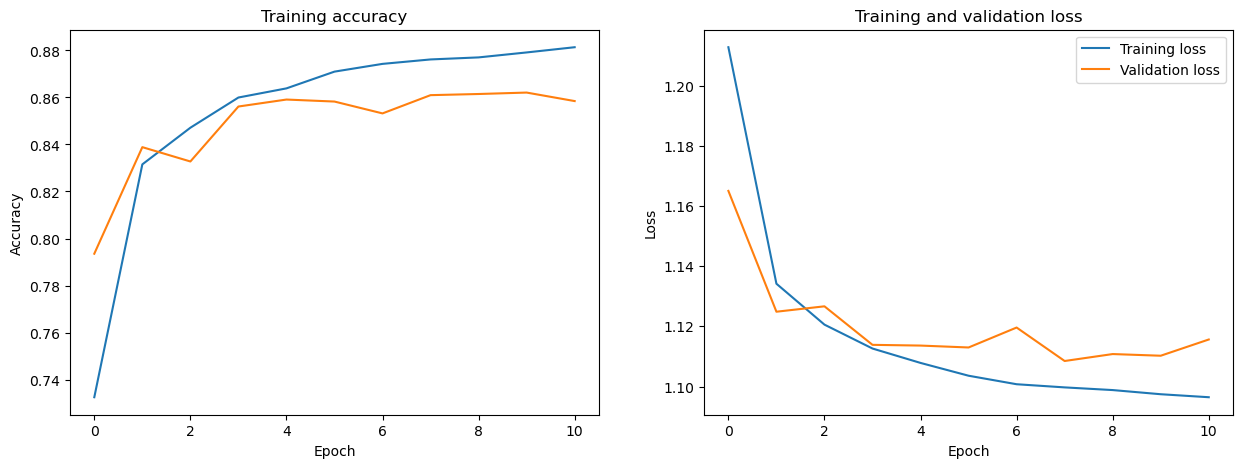

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
mlruns_path = 'mlruns/0/9c5d507c4cc248458b0253bdfaebbca9/metrics/'

train_accuracy_path = mlruns_path + 'train_accuracy'
train_loss_path = mlruns_path + 'train_loss'
val_accuracy_path = mlruns_path + 'val_accuracy'
val_loss_path = mlruns_path + 'val_loss'


# Load the metrics with pandas
train_accuracy = pd.read_csv(train_accuracy_path ,sep=' ',header=None, names=["Time", "Accuracy", "Step"])
train_loss = pd.read_csv(train_loss_path ,sep=' ', names=["Time", "Train_Loss", "Step"])
val_accuracy = pd.read_csv(val_accuracy_path ,sep=' ', names=["Time", "Accuracy", "Step"])
val_loss = pd.read_csv(val_loss_path ,sep=' ', names=["Time", "Val_Loss", "Step"])


# Plot the metrics
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_accuracy['Step'], train_accuracy['Accuracy'])
ax[0].plot(val_accuracy['Step'], val_accuracy['Accuracy'])
ax[0].set_title('Training accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[1].plot(train_loss['Step'], train_loss['Train_Loss'], label='Training loss')
ax[1].plot(val_loss['Step'], val_loss['Val_Loss'], label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.show()


# Model validation

Prediction: [1.00000, 0.00000, 0.00000, 0.00000, 0.00000]
Label:      [0.81778, 0.00000, 0.00000, 0.18222, 0.00000]


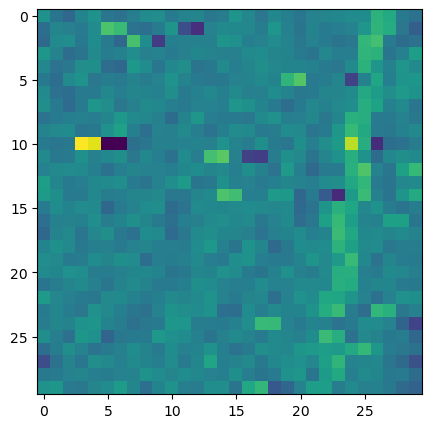

In [16]:
# Load the saved model
model_weights = torch.load('../models/state_estimator/state_estimator_early_stopping.pt')

# Create a new model instance
model = StateEstimator(model_opt='noise_opt')

# Load the model weights
model.load_state_dict(model_weights)

# Set the model to evaluation mode
model.eval()

# Get a random index
random_idx = np.random.randint(0, validation_data_transpose.shape[0])

# Get the prediction(we are returning the logit values)
prediction = model(torch.from_numpy(validation_data_transpose[random_idx, :, :, :]).unsqueeze(0).float())

# Convert the tensor to numpy array for easier formatting
pred_array = prediction.detach().numpy()[0]  # Take the first row since prediction is 2D

# Using f-string for nicer printing
pred_str = ", ".join([f"{val:.5f}" for val in pred_array])
label_str = ", ".join([f"{val:.5f}" for val in validation_labels[random_idx]])

print(f"Prediction: [{pred_str}]")
print(f"Label:      [{label_str}]")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(validation_data[random_idx, :, :, 0])
plt.show()

In [22]:
from ml_tools.preprocessing.subimage_preprocessor import SubImagePreprocessor

# Get all the .npy files in the folder
test_data_path = '../data/raw/data_qflow_v2/experimental/exp_small/'
# Get all the .npy files in the folder dataset_0, dataset_1, etc.
data_files = glob.glob(test_data_path + 'dataset_*/' + '*.npy')    

print(data_files)

# extract only what we need from the data.
# note that there is no noise_class label for experimental data
exp_data = []; exp_labels = []
for f in data_files:
    d = np.load(f, allow_pickle=True).item()
    exp_data.append(d['sensor'])
    exp_labels.append(d['label'])

# convert only labels to list because exp_data contains different shaped data.
exp_labels = np.array(exp_labels)

# preprocess
# Autoflip because sensor gradient sign is unknown. 
# Don't denoise because it doesn't help.
exp_prepper = SubImagePreprocessor(
    auto_invert=True,
    noise_reduction=[],
    clip_value=None,
    cutoff_value= None
)

proc_exp_data,exp_labels = exp_prepper.preprocess_subimages(exp_data,exp_labels)

['../data/raw/data_qflow_v2/experimental/exp_small/dataset_2/d_2_file_170.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_2/d_2_file_169.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_2/d_2_file_168.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_2/d_2_file_167.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_2/d_2_file_166.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_2/d_2_file_165.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_2/d_2_file_164.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_2/d_2_file_163.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_2/d_2_file_162.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_2/d_2_file_161.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_2/d_2_file_160.npy', '../data/raw/data_qflow_v2/experimental/exp_small/dataset_2/d_2_file_159.npy', '../data/raw/data_qflow_v2/experimental/exp_small/d

In [21]:
import torch.nn.functional as F

# Transpose the data to match the model input
proc_exp_data_transpose = np.transpose(proc_exp_data, (0, 3, 1, 2))

def compute_loss_and_accuracy(model, data, labels):
    # Convert the data and labels to PyTorch tensors
    data_tensor = torch.from_numpy(data).float()
    labels_tensor = torch.argmax(torch.from_numpy(labels), dim=1).long()

    # Pass the data through the model
    predictions = model(data_tensor)
    
    # Compute the loss
    loss = F.cross_entropy(predictions, labels_tensor)
    
    # Compute the accuracy
    predicted_labels = torch.argmax(predictions, dim=1)
    accuracy = (predicted_labels == labels_tensor).float().mean().item()
    
    return loss.item(), accuracy

# Compute the loss and accuracy for the experimental data
exp_loss, exp_accuracy = compute_loss_and_accuracy(model, proc_exp_data_transpose, exp_labels)

print(f"Experimental Data Loss: {exp_loss:.4f}")
print(f"Experimental Data Accuracy: {exp_accuracy*100:.2f}%")


Experimental Data Loss: 1.0860
Experimental Data Accuracy: 81.87%
